# Putting it all together - Building a value-weighted index
> A Summary of lecture "Manipulating Time Series Data in Python", via datacamp

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Time_Series_Analysis]
- image: images/market_cap.png

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 5)

## Select index components & import data
- Market value-weighted index
    - Composite performance of various stocks
    - Components weighted by market capitalization
        - ```Share Price``` * ```Number of Shares``` => ```Market Value```
    - Larger components get higher percentage weightings
    - Key market indexes are value-weighted
        - S&P500, NASDAQ, Wilshire 5000, Hang Seng, ...
- Build a cap-weighted Index
    - Apply new skills to construct value-weighted index
        - Select components from exchange listing data
        - Get component number of shares and stock prices
        - Calculate component weights
        - Calculate index
        - Evaluate performance of components and index

### Explore and clean company listing information
To get started with the construction of a market-value based index, you'll work with the combined listing info for the three largest US stock exchanges, the NYSE, the NASDAQ and the AMEX.

In this and the next exercise, you will calculate market-cap weights for these stocks.

In [2]:
listings_nyse = pd.read_excel('./dataset/listings.xlsx', sheet_name='nyse', na_values='n/a')
listings_amex = pd.read_excel('./dataset/listings.xlsx', sheet_name='amex', na_values='n/a')
listings_nasdaq = pd.read_excel('./dataset/listings.xlsx', sheet_name='nasdaq', na_values='n/a')

In [3]:
listings_nyse['Exchange'] = 'nyse'
listings_amex['Exchange'] = 'amex'
listings_nasdaq['Exchange'] = 'nasdaq'

In [4]:
listings = pd.concat([listings_amex, listings_nasdaq, listings_nyse], axis=0)
listings.reset_index(inplace=True)
listings.drop(['index'], axis=1, inplace=True)
listings['Market Capitalization'] /= 1e6

In [5]:
# Inspect listings
print(listings.info())

# Move 'stock symbol' into the index
listings.set_index('Stock Symbol', inplace=True)

# Drop rows with missing 'sector' data
listings.dropna(subset=['Sector'], inplace=True)

# Select companies with IPO Year befor 2019
listings = listings[listings['IPO Year'] < 2019]

# Inspect the new listings data
print(listings.info())

# Show the number of companies per sector
print(listings.groupby('Sector').size().sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6674 entries, 0 to 6673
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Stock Symbol           6674 non-null   object 
 1   Company Name           6674 non-null   object 
 2   Last Sale              6590 non-null   float64
 3   Market Capitalization  6674 non-null   float64
 4   IPO Year               2852 non-null   float64
 5   Sector                 5182 non-null   object 
 6   Industry               5182 non-null   object 
 7   Exchange               6674 non-null   object 
dtypes: float64(3), object(5)
memory usage: 417.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 2349 entries, ACU to ZTO
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Company Name           2349 non-null   object 
 1   Last Sale              2349 non-null   float64
 2   

### Select and inspect index components
Now that you have imported and cleaned the listings data, you can proceed to select the index components as the largest company for each sector by market capitalization.

You'll also have the opportunity to take a closer look at the components, their last market value, and last price.

In [6]:
# Select largest company for each sector
components = listings.groupby('Sector')['Market Capitalization'].nlargest(1)

# Print components, sorted by market cap
print(components.sort_values(ascending=False))

# Select stock symbols and print the result
tickers = components.index.get_level_values('Stock Symbol')
print(tickers)

# Print company name, market cap, and last price for each components
info_cols = ['Company Name', 'Market Capitalization', 'Last Sale']
print(listings.loc[tickers,info_cols].sort_values('Market Capitalization', ascending=False))

Sector                 Stock Symbol
Technology             AAPL            740024.467000
Consumer Services      AMZN            422138.530626
Miscellaneous          BABA            275525.000000
Health Care            AMGN            118927.210535
Transportation         UPS              90180.886756
Finance                GS               88840.590477
Consumer Non-Durables  ABEV             88240.198455
Basic Industries       RIO              70431.476895
Public Utilities       TEF              54609.806092
Capital Goods          GM               50086.335099
Energy                 PAA              22223.001416
Consumer Durables      CPRT             13620.922869
Name: Market Capitalization, dtype: float64
Index(['RIO', 'GM', 'CPRT', 'ABEV', 'AMZN', 'PAA', 'GS', 'AMGN', 'BABA', 'TEF',
       'AAPL', 'UPS'],
      dtype='object', name='Stock Symbol')
                                    Company Name  Market Capitalization  \
Stock Symbol                                                   

### Import index component price information
Now you'll use the stock symbols for the companies you selected in the last exercise to calculate returns for each company.



In [7]:
tickers = tickers.tolist()

['RIO', 'GM', 'CPRT', 'ABEV', 'AMZN', 'PAA', 'GS', 'AMGN', 'BABA', 'TEF', 'AAPL', 'UPS']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1761 non-null   float64
 1   AMGN    1761 non-null   float64
 2   AMZN    1761 non-null   float64
 3   CPRT    1761 non-null   float64
 4   EL      1762 non-null   float64
 5   GS      1762 non-null   float64
 6   ILMN    1761 non-null   float64
 7   MA      1762 non-null   float64
 8   PAA     1762 non-null   float64
 9   RIO     1762 non-null   float64
 10  TEF     1762 non-null   float64
 11  UPS     1762 non-null   float64
dtypes: float64(12)
memory usage: 179.0 KB
None


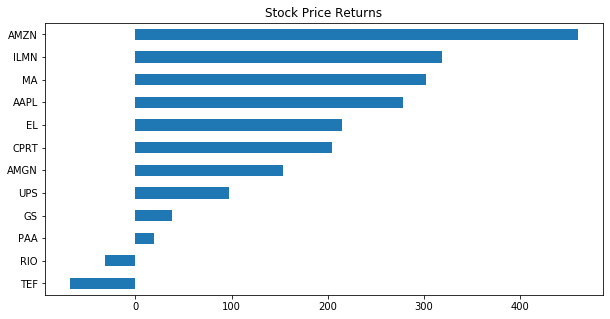

In [8]:
# Print tickers
print(tickers)

# Import prices and inspect result
stock_prices = pd.read_csv('./dataset/stocks_4.csv', parse_dates=['Date'], index_col='Date')
print(stock_prices.info())

# Calculate the returns
price_return = stock_prices.iloc[-1].div(stock_prices.iloc[0]).sub(1).mul(100)

# Plot horizontal bar chart of sorted price_return
price_return.sort_values().plot(kind='barh', title='Stock Price Returns');

## Build a market-cap weighted index


### Calculate number of shares outstanding
The next step towards building a value-weighted index is to calculate the number of shares for each index component.

The number of shares will allow you to calculate the total market capitalization for each component given the historical price series in the next exercise.

In [9]:
# Inspect listings and print tickers
print(listings.info())
print(tickers)

# Select components and relevant columns from listings
components = listings[['Market Capitalization', 'Last Sale']].loc[tickers]

# Print the first rows of components
print(components.head(5))

# Calculate the number of shares here
no_shares = components['Market Capitalization'].div(components['Last Sale'])

# Print the sorted no_shares
print(no_shares.sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
Index: 2349 entries, ACU to ZTO
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Company Name           2349 non-null   object 
 1   Last Sale              2349 non-null   float64
 2   Market Capitalization  2349 non-null   float64
 3   IPO Year               2349 non-null   float64
 4   Sector                 2349 non-null   object 
 5   Industry               2349 non-null   object 
 6   Exchange               2349 non-null   object 
dtypes: float64(3), object(4)
memory usage: 226.8+ KB
None
['RIO', 'GM', 'CPRT', 'ABEV', 'AMZN', 'PAA', 'GS', 'AMGN', 'BABA', 'TEF', 'AAPL', 'UPS']
              Market Capitalization  Last Sale
Stock Symbol                                  
RIO                    70431.476895      38.94
GM                     50086.335099      33.39
CPRT                   13620.922869      29.65
ABEV                   88240.198455       5.62


### Create time series of market value
You can now use the number of shares to calculate the total market capitalization for each component and trading date from the historical price series.

The result will be the key input to construct the value-weighted stock index, which you will complete in the next exercise.

In [10]:
components['Number of Shares'] = no_shares

Stock Symbol
GS        397.817439
CPRT      459.390316
AMZN      477.170618
PAA       723.404994
AMGN      735.890171
UPS       869.297154
GM       1500.039985
RIO      1808.717948
BABA     2500.000000
TEF      5037.804990
AAPL     5246.540000
ABEV    15701.102928
Name: Number of Shares, dtype: float64


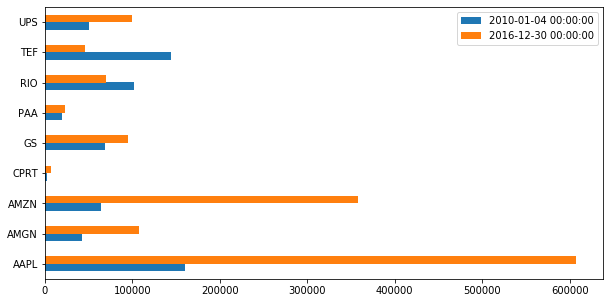

In [14]:
# Select the number of shares
no_shares = components['Number of Shares']
print(no_shares.sort_values())

# Create the series of market cap per ticker
market_cap = stock_prices.mul(no_shares)

# Select first and last market cap here
first_value = market_cap.iloc[0]
last_value = market_cap.iloc[-1]

# Concatenate and plot first and last market cap here
pd.concat([first_value, last_value], axis=1).dropna().plot(kind='barh');
plt.savefig('../images/market_cap.png')
plt.show()

### Calculate & plot the composite index
By now you have all ingredients that you need to calculate the aggregate stock performance for your group of companies.

Use the time series of market capitalization that you created in the last exercise to aggregate the market value for each period, and then normalize this series to convert it to an index.

In [12]:
market_cap_series = market_cap[pd.concat([first_value, last_value], axis=1).dropna().index.tolist()]

In [13]:
market_cap_series

AAPL           AMGN           AMZN         CPRT  \
Date                                                                 
2010-01-04  160386.7278   42475.580670   63893.145750  2090.225938   
2010-01-05  160701.5202   42107.635585   64270.110538  2090.225938   
2010-01-06  158130.7156   41791.202811   63105.814231  2081.038131   
2010-01-07  157815.9232   41408.539922   62032.180340  2067.256422   
2010-01-08  158865.2312   41776.485008   63711.820915  2076.444228   
...                 ...            ...            ...          ...   
2016-12-23  611326.8408  108580.594731  362931.200345  6380.931489   
2016-12-27  615209.2804  109176.665770  368089.414725  6431.464424   
2016-12-28  612586.0104  108668.901552  368437.749276  6380.931489   
2016-12-29  612428.6142  108749.849470  365107.098363  6376.337586   
2016-12-30  607654.2628  107594.501902  357815.931320  6362.555877   

                      GS           PAA            RIO            TEF  \
Date                                                                   
2010-01-04  68854.242342  19531.934838  101342.466626  143829.332464   
2010-01-05  70071.563705  19748.956336  102916.051241  143728.576365   
2010-01-06  69323.666920  19741.722286  106063.220471  142217.234868   
2010-01-07  70680.224387  19502.998638  106081.307650  139799.088472   
2010-01-08  69343.557792  19568.105088  107256.974316  138892.283574   
...                  ...           ...            ...            ...   
2016-12-23  95862.068276  24168.960850   68948.328178   46196.671758   
2016-12-27  96096.780565  24226.833249   69364.333306   45995.159559   
2016-12-28  95734.766695  23908.535052   70304.866639   45491.379060   
2016-12-29  94752.157621  23488.960155   70359.128177   45995.159559   
2016-12-30  95257.385769  23358.747256   69563.292280   46347.805908   

                      UPS  
Date                       
2010-01-04   50575.708420  
2010-01-05   50662.638135  
2010-01-06   50288.840359  
2010-01-07   49906.349611  
2010-01-08   52305.609756  
...                   ...  
2016-12-23  100812.390949  
2016-12-27  100951.478494  
2016-12-28  100143.032141  
2016-12-29   99951.786767  
2016-12-30   99656.225735  

[1762 rows x 9 columns]

Date
2010-01-04    6.529794e+05
2010-01-05    6.562973e+05
2010-01-06    6.527435e+05
2010-01-07    6.492939e+05
2010-01-08    6.537965e+05
                  ...     
2016-12-23    1.425208e+06
2016-12-27    1.435541e+06
2016-12-28    1.431656e+06
2016-12-29    1.427209e+06
2016-12-30    1.413611e+06
Length: 1762, dtype: float64
Date
2010-01-04    100.000000
2010-01-05    100.508119
2010-01-06     99.963872
2010-01-07     99.435588
2010-01-08    100.125141
                 ...    
2016-12-23    218.262332
2016-12-27    219.844835
2016-12-28    219.249834
2016-12-29    218.568789
2016-12-30    216.486276
Length: 1762, dtype: float64


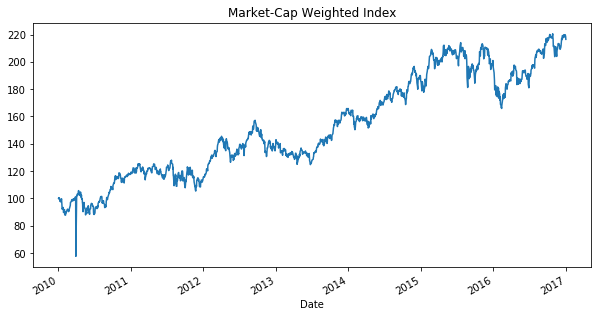

In [55]:
# Aggregate and print the market cap per trading day
raw_index = market_cap_series.sum(axis=1)
print(raw_index)

# Normalize the aggregate market cap here
index = raw_index.div(raw_index.iloc[0]).mul(100)
print(index)

# Plot the index here
index.plot(title='Market-Cap Weighted Index');

## Evaluate index performance
- Index return:
    - Total index return
    - Contribution by component
- Performance vs Benchmark
    - Total period return
    - Rolling returns for sub periods

### Calculate the contribution of each stock to the index
You have successfully built the value-weighted index. Let's now explore how it performed over the 2010-2016 period.

Let's also determine how much each stock has contributed to the index return.

116.48627582170698
Stock Symbol
CPRT    0.006694
PAA     0.010921
GM      0.024614
TEF     0.026837
RIO     0.034613
ABEV    0.043365
GS      0.043660
UPS     0.044318
AMGN    0.058445
BABA    0.135403
AMZN    0.207455
AAPL    0.363675
Name: Market Capitalization, dtype: float64


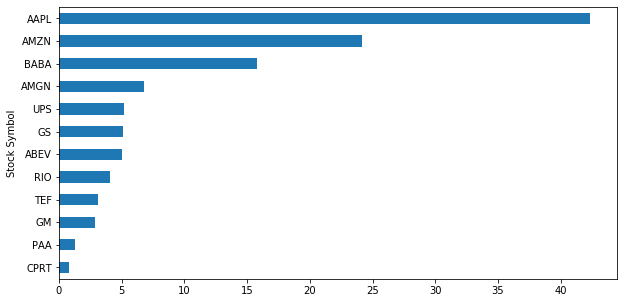

In [58]:
# Calculate and print the index return here
index_return = (index.iloc[-1] / index.iloc[0] - 1) * 100
print(index_return)

# Select the market capitalization
market_cap = components['Market Capitalization']

# Calculate the total market cap
total_market_cap = market_cap.sum()

# Calculate the component weights , and print the result
weights = market_cap.div(total_market_cap)
print(weights.sort_values())

# Calculate and plot the distribution by component
weights.mul(index_return).sort_values().plot(kind='barh');

### Compare index performance against benchmark I
The next step in analyzing the performance of your index is to compare it against a benchmark.

In the video, we used the S&P 500 as benchmark. You can also use the Dow Jones Industrial Average, which contains the 30 largest stocks, and would also be a reasonable benchmark for the largest stocks from all sectors across the three exchanges.

In [64]:
djia = pd.read_csv('./dataset/djia2.csv', parse_dates=['DATE'], index_col='DATE')['DJIA']

Index    116.486276
DJIA      86.722172
dtype: float64


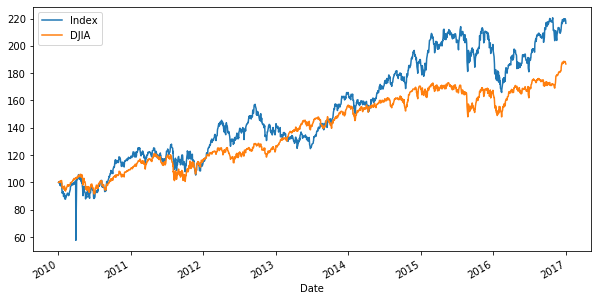

In [68]:
# Convert index series to dataframe here
data = index.to_frame('Index')

# Normalize djia series and add as new column to data
djia = djia.div(djia.iloc[0]).mul(100)
data['DJIA'] = djia

# Print total return for both index and djia
print((data.iloc[-1] / data.iloc[0] - 1) * 100)

# Plot both series
data.plot();

### Compare index performance against benchmark II
The next step in analyzing the performance of your index is to compare it against a benchmark.

In the video, we have use the S&P 500 as benchmark. You can also use the Dow Jones Industrial Average, which contains the 30 largest stocks, and would also be a reasonable benchmark for the largest stocks from all sectors across the three exchanges.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   1762 non-null   float64
 1   DJIA    1762 non-null   float64
dtypes: float64(2)
memory usage: 41.3 KB
None
                 Index        DJIA
Date                              
2010-01-04  100.000000  100.000000
2010-01-05  100.508119   99.887188
2010-01-06   99.963872   99.902872
2010-01-07   99.435588  100.216365
2010-01-08  100.125141  100.323414


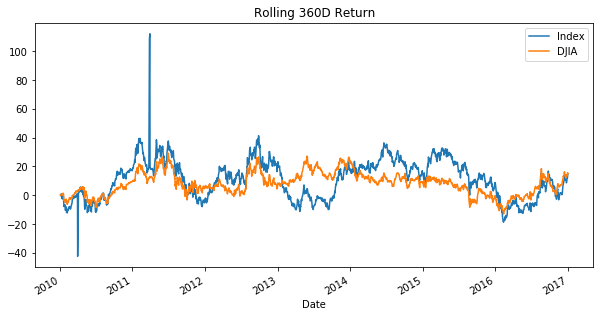

In [70]:
# Inspect data
print(data.info())
print(data.head(5))

# Create multi_period_return function here
def multi_period_return(r):
    return (np.prod(r + 1) - 1) * 100

# Calculate rolling_return_360
rolling_return_360 = data.pct_change().rolling('360D').apply(multi_period_return)

# Plot rolling_return_360 here
rolling_return_360.plot(title='Rolling 360D Return');
plt.show()

## Index correlation & exporting to Excel


### Visualize your index constituent correlations
To better understand the characteristics of your index constituents, you can calculate the return correlations.

Use the daily stock prices or your index companies, and show a heatmap of the daily return correlations!

In [71]:
stock_prices = pd.read_csv('./dataset/stocks_4.csv', parse_dates=['Date'], index_col='Date')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1761 non-null   float64
 1   AMGN    1761 non-null   float64
 2   AMZN    1761 non-null   float64
 3   CPRT    1761 non-null   float64
 4   EL      1762 non-null   float64
 5   GS      1762 non-null   float64
 6   ILMN    1761 non-null   float64
 7   MA      1762 non-null   float64
 8   PAA     1762 non-null   float64
 9   RIO     1762 non-null   float64
 10  TEF     1762 non-null   float64
 11  UPS     1762 non-null   float64
dtypes: float64(12)
memory usage: 179.0 KB
None
          AAPL      AMGN      AMZN      CPRT        EL        GS      ILMN  \
AAPL  1.000000  0.286898  0.327611  0.346616  0.306770  0.344981  0.264791   
AMGN  0.286898  1.000000  0.323408  0.355892  0.349893  0.390076  0.336927   
AMZN  0.327611  0.323408  1.000000  0.298929  0.334031  0.333402  0.242726 

Text(0.5, 1, 'Daily Return Correlations')

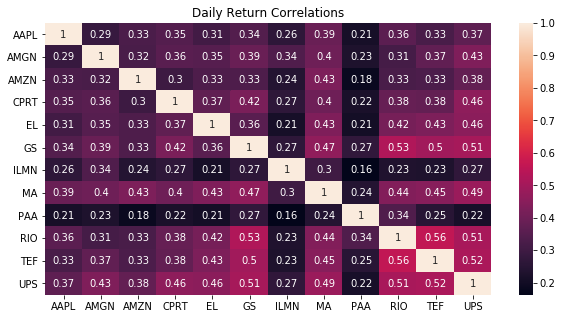

In [73]:
# Inspect stock_prices here
print(stock_prices.info())

# Calculate the dail returns
returns = stock_prices.pct_change()

# Calculate and print the pairwise correlations
correlations = returns.corr()
print(correlations)

# Plot a heatmap of daily return correlations
sns.heatmap(correlations, annot=True);
plt.title('Daily Return Correlations')

### Save your analysis to multiple excel worksheets
Now that you have completed your analysis, you may want to save all results into a single Excel workbook.

Let's practice exporting various ```DataFrame``` to multiple Excel worksheets.

In [79]:
index = index.to_frame('Index')

In [80]:
# Inspect index and stock_prices
print(index.info())
print(stock_prices.info())

# Join index to stock_prices, and inspect the result
data = stock_prices.join(index)
print(data.info())

# Create index & stock price returns
returns = data.pct_change()

# Export data and data as returns to excel
with pd.ExcelWriter('data.xls') as writer:
    data.to_excel(writer, sheet_name='data')
    returns.to_excel(writer, sheet_name='returns')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   1762 non-null   float64
dtypes: float64(1)
memory usage: 27.5 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1761 non-null   float64
 1   AMGN    1761 non-null   float64
 2   AMZN    1761 non-null   float64
 3   CPRT    1761 non-null   float64
 4   EL      1762 non-null   float64
 5   GS      1762 non-null   float64
 6   ILMN    1761 non-null   float64
 7   MA      1762 non-null   float64
 8   PAA     1762 non-null   float64
 9   RIO     1762 non-null   float64
 10  TEF     1762 non-null   float64
 11  UPS     1762 non-null   float64
dtypes: float64(12)
memory usage: 179.0 KB
None
<class 'pandas.core.frame.Da